In [87]:
# Main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ETL libraries
from ETL import ETL

# Scikit-learn: Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn: Models
from sklearn.linear_model import LinearRegression

# Scikit-learn: Testing and evaluation
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Category Encoders
from category_encoders import TargetEncoder

In [88]:
df = pd.read_csv('dataset/flights.csv')

In [89]:
df = ETL(df)

# ETL for regression

In [90]:
drop_features = [
    'CRS_DEP_TIME', 'CRS_ARR_TIME',
    'FL_YEAR', 'DEP_TIME', 'ARR_TIME',
    'WHEELS_OFF', 'WHEELS_ON', 'DEP_DELAY'
    'FL_MON', 'FL_DAY', 'CRS_ELAPSED_TIME',	'ACTUAL_ELAPSED_TIME',
    'FL_DATE', 'AIR_TIME', 'DISTANCE',
]
df = df.drop(columns=drop_features, errors='ignore')

In [91]:
categorical_features = ['OP_CARRIER', 'C_REASON','FL_DOW']

standard_features = [
    'TAXI_OUT', 'TAXI_IN', 'DEP_DELAY',
    'ACT_TO_CRS_RATIO', 'ARR_DELAY',
]

min_max_scaler = MinMaxScaler()

# Standardizzazione delle variabili con outliers
df[standard_features] = min_max_scaler.fit_transform(df[standard_features])

In [92]:
# Inizializza il Target Encoder
encoder = TargetEncoder()

# Applica il target encoding su ORIGIN e DEST
df['ORIGIN'] = encoder.fit_transform(df['ORIGIN'], df['ARR_DELAY'])
df['DEST'] = encoder.fit_transform(df['DEST'], df['ARR_DELAY'])

In [93]:
df = pd.get_dummies(df)

# Crea le colonne dummies per 'FL_DOW'
fl_dow_dummies = pd.get_dummies(df['FL_DOW'], prefix='FL_DOW')

# Aggiungi le nuove colonne dummies al DataFrame
df = pd.concat([df, fl_dow_dummies], axis=1)

# Se vuoi, puoi eliminare la colonna originale 'FL_DOW'
df = df.drop('FL_DOW', axis=1)


In [94]:
df = df.drop(columns='OP_CARRIER_FL_NUM', errors='ignore')

# Replace NaNs with a placeholder category
df.fillna(False, inplace=True)
df.head()

,ORIGIN,DEST,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,CANCELLED,DIVERTED,ACT_TO_CRS_RATIO,FL_MON,...,C_REASON_Not cancelled,C_REASON_Security,C_REASON_Weather,FL_DOW_0,FL_DOW_1,FL_DOW_2,FL_DOW_3,FL_DOW_4,FL_DOW_5,FL_DOW_6
0,0.119997,0.121453,0.120859,0.026432,0.008658,0.109530,0.0,0.0,0.160497,1,...,True,False,False,False,False,False,True,False,False,False
1,0.122252,0.125858,0.127607,0.057269,0.021645,0.120050,0.0,0.0,0.166327,1,...,True,False,False,False,False,False,True,False,False,False
2,0.123774,0.123667,0.119632,0.088106,0.017316,0.121287,0.0,0.0,0.197895,1,...,True,False,False,False,False,False,True,False,False,False
3,0.123070,0.122048,0.123313,0.057269,0.017316,0.109530,0.0,0.0,0.176896,1,...,True,False,False,False,False,False,True,False,False,False
4,0.121473,0.123285,0.120245,0.044053,0.030303,0.113243,0.0,0.0,0.183183,1,...,True,False,False,False,False,False,True,False,False,False


# Regression

In [95]:
y = df['ARR_DELAY']
x = df.drop(columns=['ARR_DELAY'])


# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(95416, 44)
(23855, 44)
(95416,)
(23855,)


In [96]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [97]:
# Predizioni sui dati di test
y_pred = model.predict(x_test)

r2_test = r2_score(y_test, y_pred)
print("R^2 Score (Test):", r2_test)

# Calcolare MSE e RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

R^2 Score (Test): 0.9715912782823943
RMSE: 0.0040944747269441376


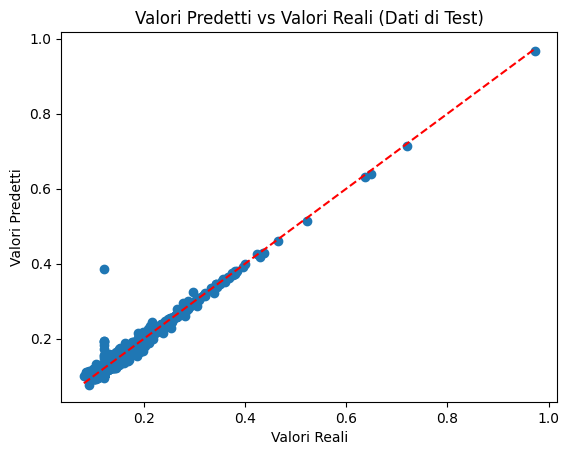

In [98]:
plt.scatter(y_test, y_pred)  # Usa y_test e y_pred per il confronto sui dati di test
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Valori Predetti vs Valori Reali (Dati di Test)')
plt.show()


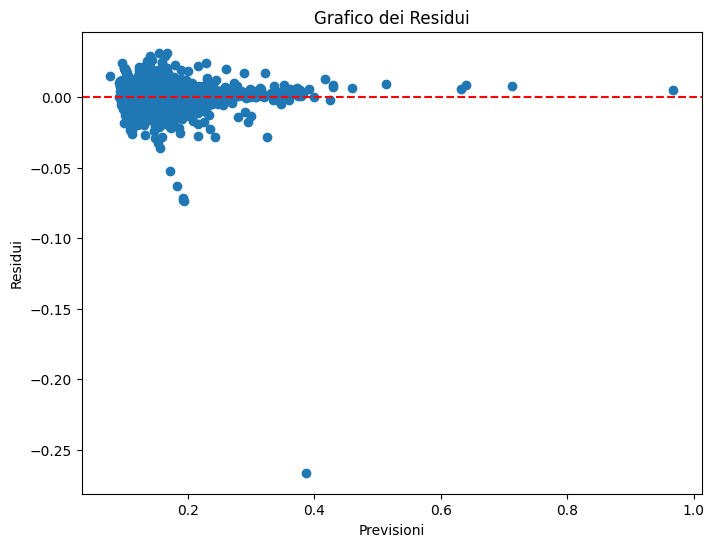

In [99]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Previsioni')
plt.ylabel('Residui')
plt.title('Grafico dei Residui')
plt.show()

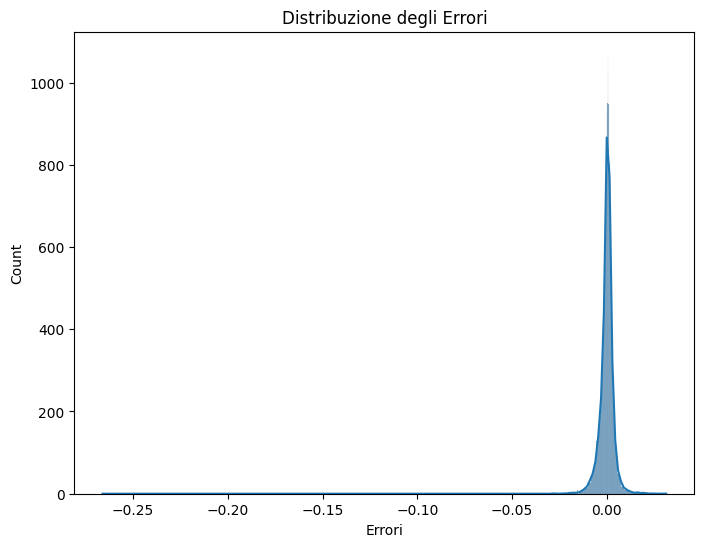

In [100]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Errori')
plt.title('Distribuzione degli Errori')
plt.show()

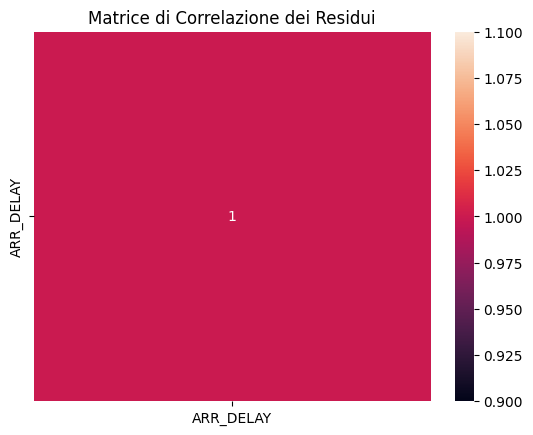

In [101]:
residuals = y_test - y_pred  # Usa y_test invece di y_train
residuals_df = pd.DataFrame(residuals)
correlation_matrix = residuals_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Matrice di Correlazione dei Residui')
plt.show()
